# Descripción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85

# Introducción

### Visión general
El objetivo principal de este proyecto es evaluar y comparar un espectro de modelos de aprendizaje automático y aprendizaje profundo en su capacidad para realizar análisis de sentimientos sobre una colección de críticas de películas y productos. Al categorizar los sentimientos en clases positivas, negativas o neutrales, el proyecto busca identificar los modelos que reflejan con mayor precisión los matices de los sentimientos expresados en datos textuales.

Objetivos del proyecto:

- Comparar modelos tradicionales de aprendizaje automático (como SVM lineal, Regresión Logística y LightGBM) con técnicas avanzadas de aprendizaje profundo (como aquellas que utilizan incrustaciones BERT) en el contexto del análisis de sentimientos.
- Evaluar la efectividad de diferentes técnicas de extracción de características, incluyendo la vectorización TF-IDF y las incrustaciones BERT, en capturar la riqueza semántica del texto para el análisis de sentimientos.
- Identificar las fortalezas y debilidades de cada modelo, orientando así la selección de las técnicas más apropiadas para el análisis de sentimientos en tipos específicos de datos textuales y dominios de aplicación.

Proceso metodológico:

. Preparación de datos: El primer paso implica la recolección y preprocesamiento de datos textuales (críticas de películas y productos) para crear un conjunto de datos estandarizado adecuado para el entrenamiento y evaluación de modelos.
- Extracción de características: Esta fase aplica la vectorización TF-IDF para transformar el texto en características numéricas para modelos tradicionales y utiliza incrustaciones BERT para modelos de aprendizaje profundo, con el objetivo de capturar la esencia semántica del texto.
- Entrenamiento y evaluación del modelo: Se entrenan múltiples modelos de aprendizaje automático y aprendizaje profundo con los datos procesados. Su rendimiento se evalúa utilizando métricas como precisión, recall, y F1-score para medir su efectividad en el análisis de sentimientos.
- Comparación y análisis: Se comparan los resultados de diferentes modelos para analizar su rendimiento en la comprensión y categorización de sentimientos. Esta comparación arroja luz sobre cómo diversos enfoques modelan las complejidades del lenguaje humano y la emoción.

Mediante este enfoque integral, el proyecto busca avanzar en la comprensión de las metodologías de análisis de sentimientos y sus aplicaciones prácticas, contribuyendo en última instancia a un análisis más efectivo y matizado de los sentimientos humanos en datos textuales.

## Inicialización

In [1]:
import math
import numpy as np
import pandas as pd
import re
import spacy
import torch
import transformers
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import nltk
import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from tqdm import tqdm
from lightgbm import LGBMClassifier
from transformers import BertTokenizer, BertModel, BertConfig

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/users/Alejandro/Downloads/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

In [17]:
df_reviews.sample(10)

In [6]:
# Veamos si existen valore ausentes en nuestro Dataframe
missing_values = df_reviews.isnull().sum()

# Corroboramos imprimiendo
print(missing_values)

Para el propósito del análisis de sentimientos centrado en clasificar críticas de películas como positivas o negativas, las columnas a **average_rating** y votes no son directamente relevantes. El interés principal radica en el contenido textual de las críticas (**review** column) y sus etiquetas de sentimiento asociadas (**pos** column). Las columnas **average_rating** y **votes** están más relacionadas con la recepción general del público hacia una película, lo cual, aunque interesante para otros tipos de análisis (por ejemplo, correlacionar la recepción del público con el sentimiento de las críticas), no contribuyen a la tarea de clasificación de sentimientos basada en el texto de las críticas en sí.

In [7]:
# Obtenenemos recuentos simples para la pos column (sentimiento).
print("Distribución de sentimientos:")
print("Positive = 1; Negative = 0")
print(df_reviews['pos'].value_counts())
print("\n")

# Obtenemos recuentos simples para la columna 'ds_part' (partición del conjunto de datos).
print("Distribuciones de la partición del conjunto de datos (Train/Test):")
print(df_reviews['ds_part'].value_counts())
print("\n")

# 'title_type' y 'genres' pueden tener múltiples categorías, y 'genres' puede ser una combinación,
# es útil explorarlos en busca de ideas, pero teniendo en cuenta la complejidad de'genres'.
print("Distribución de tipos de títulos:")
print(df_reviews['title_type'].value_counts())
print("\n")

# Para 'genres', considerar las combinaciones únicas o tal vez las N principales si hay muchas combinaciones únicas.
print("Distribución de géneros (Top 10):")
print(df_reviews['genres'].value_counts().head(10))
print("\n")

# Obtener recuentos simples para la columna 'is_adult'
print("Distribución de clasificacion para adultos:")
print(df_reviews['is_adult'].value_counts())

Observar las distribuciones a través de diferentes dimensiones de un conjunto de datos es fundamental para entender su estructura, posibles sesgos y áreas que pueden requerir atención especial durante el preprocesamiento de datos y el entrenamiento del modelo. Aquí está lo que podemos concluir a partir de las distribuciones proporcionadas:

- El conjunto de datos está casi perfectamente equilibrado entre críticas positivas y negativas (23,715 negativas, 23,616 positivas). Este equilibrio es beneficioso para entrenar modelos de análisis de sentimientos, ya que reduce el riesgo de que un modelo tenga sesgo hacia la predicción de un sentimiento sobre el otro. No son necesarias técnicas especiales de balanceo (por ejemplo, sobremuestreo, submuestreo) basadas en esta distribución.
- Los conjuntos de datos de train y test también están casi equilibrados (23,796 en entrenamiento, 23,535 en prueba), lo que indica que la división se realizó de manera cuidadosa para asegurar que ambos conjuntos sean representativos de los datos generales.
- La mayoría de las críticas son para películas, con significativamente menos críticas para otros tipos como tvMovie, video y tvSeries. Esto indica que cualquier modelo de análisis de sentimientos entrenado en este conjunto de datos podría funcionar mejor en críticas de películas y potencialmente con menos precisión en otros tipos de medios debido a su menor representación en los datos de entrenamiento.
- La distribución de géneros muestra una variedad con Drama siendo el más común, seguido por Comedia y combinaciones específicas como Drama, Romance y Terror. Esta diversidad es buena para construir un modelo que pueda entender sentimientos a través de diferentes géneros. Sin embargo, es posible que el modelo sea más preciso para géneros con más datos (como Drama y Comedia) y menos preciso para géneros menos representados.
- La gran mayoría de las críticas son para contenido no adulto (47,249 no adulto frente a 82 adulto). Este desequilibrio extremo sugiere que cualquier modelo de análisis de sentimientos desarrollado podría no funcionar bien en contenido adulto debido a la falta de datos de entrenamiento en esta categoría.

In [8]:
df_reviews.duplicated().sum()

El conjunto de datos no tiene duplicados, lo que significa que cada entrada es única, lo cual ayuda en el entrenamiento de un modelo sin la preocupación de sobreajuste a entradas repetidas.

Con el conjunto de datos verificado por valores faltantes, duplicados y habiendo comprendido su distribución en diversas dimensiones, estamos preparados para pasar al siguiente paso.

## EDA

Se analizan el número de películas y reseñas a lo largo de los años.

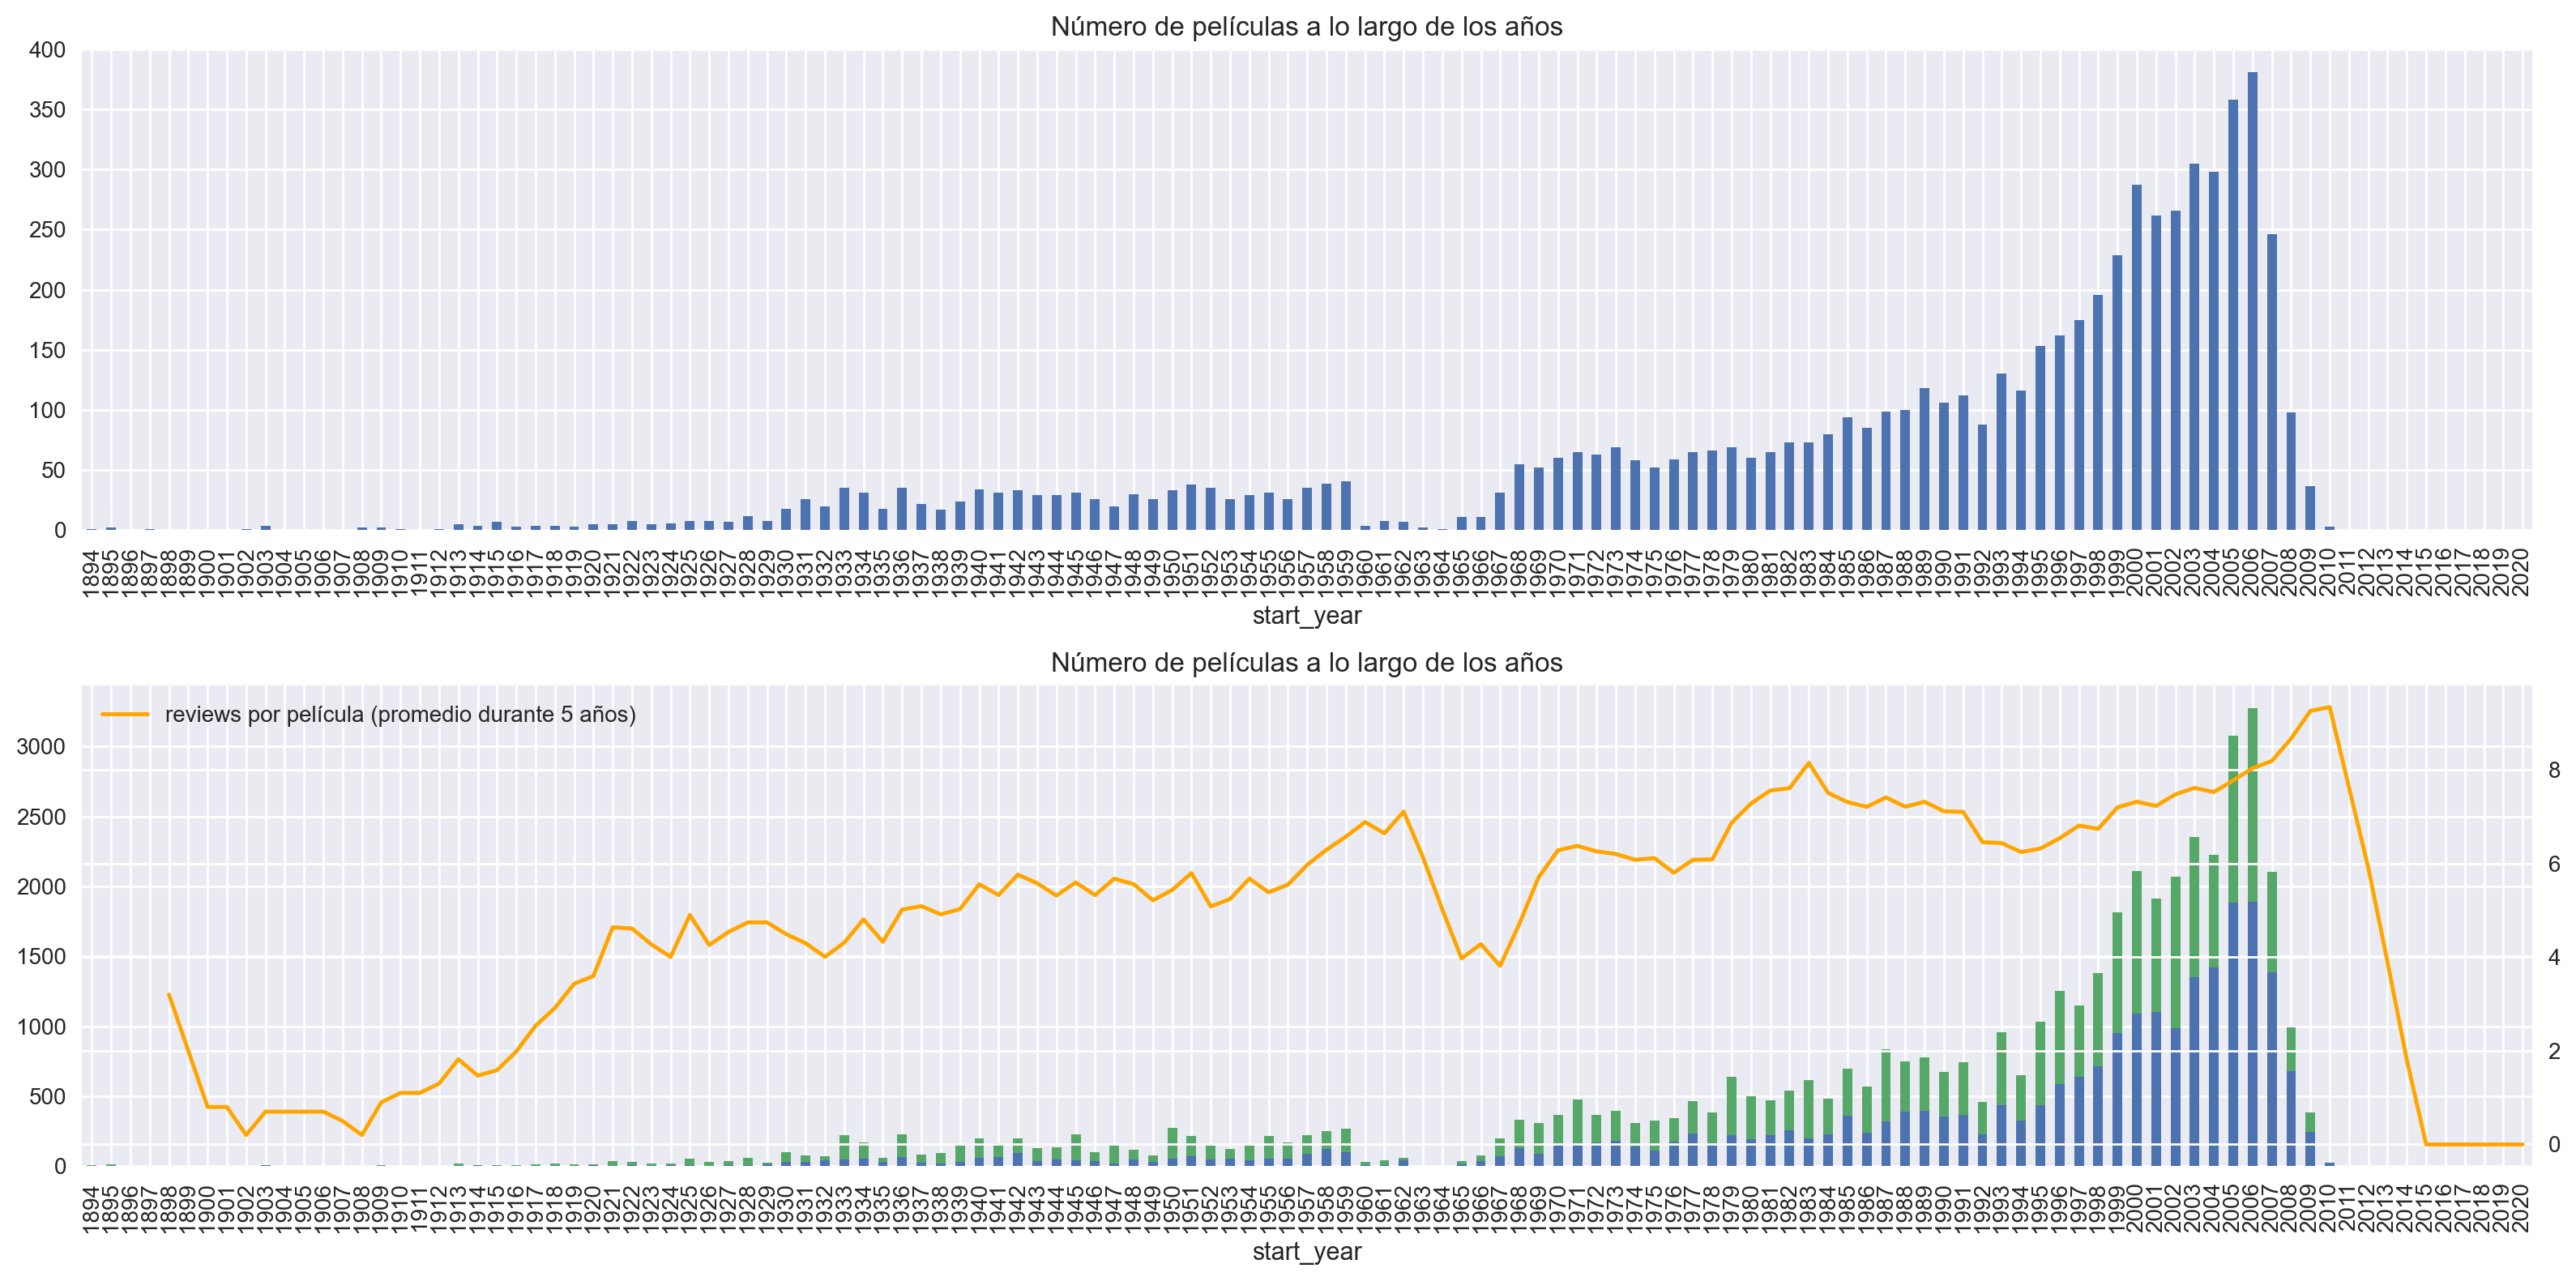

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews por película (promedio durante 5 años)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de películas a lo largo de los años')

fig.tight_layout()

In [10]:
# Ajusta el rango a los últimos 10 años que terminan en 2010.
last_10_years = np.arange(2001, 2011)

# 1. Tendencia general en el número de películas durante los últimos 10 años que terminan en 2010.
movies_last_10_years = dft1.loc[last_10_years]
movie_count_trend_last_10_years = movies_last_10_years.mean()

# 2. Año con el mayo número de películas en los últimso 10 años que terminan en 2010
year_max_movies_last_10_years = movies_last_10_years.idxmax()

# 3. Tendencia general en el número de reseñas durante los últimos 10 años que terminan en 2010
reviews_last_10_years = dft2.loc[last_10_years]
review_count_trend_last_10_years = reviews_last_10_years.mean()

# 4. Año con el máximo número de reseñas en los últimos 10 años que terminan en 2010
year_max_reviews_last_10_years = reviews_last_10_years.idxmax()

# 5. Promedio de número de reseñas por película durante los últimos 5 años que terminan en 2010
# Ajustar el rango a los últimos 5 años que terminan en 2010
last_5_years = np.arange(2006, 2011)
reviews_per_movie_last_5_years = dft3.loc[last_5_years]
avg_reviews_per_movie_last_5_years = reviews_per_movie_last_5_years.mean()

# Printing the key data points
print(f"Tendencia general en el número de películas durante los últimos 10 años que terminan en 2010: {movie_count_trend_last_10_years}")
print(f"Año con el número máximo de películas en los últimos 10 años que terminan en 2010: {year_max_movies_last_10_years}")
print(f"Tendencia general en el número de reseñas durante los últimos 10 años que terminan en 2010: {review_count_trend_last_10_years}")
print(f"Año con el máximo número de reseñas en los últimos 10 años que terminan en 2010: {year_max_reviews_last_10_years}")
print(f"Promedio de número de reseñas por película durante los últimos 5 años que terminan en 2010: {avg_reviews_per_movie_last_5_years}")

En promedio, hubo 225.4 películas por año durante los últimos 10 años que terminaron en 2010. El año 2006 tuvo el mayor número de películas en comparación con los otros años de esa década. Al igual que el número de películas, 2006 también registró la mayor cantidad de reseñas. Hubo un promedio de 1842.7 reseñas por año en la última década hasta 2010. En los últimos 5 años que terminaron en 2010, hubo un promedio de aproximadamente 9.34 reseñas por película.

Vamos a verificar la distribución del número de reseñas por película utilizando el conteo exacto y la estimación de densidad kernel (KDE), solo para aprender cómo puede diferir del conteo exacto.

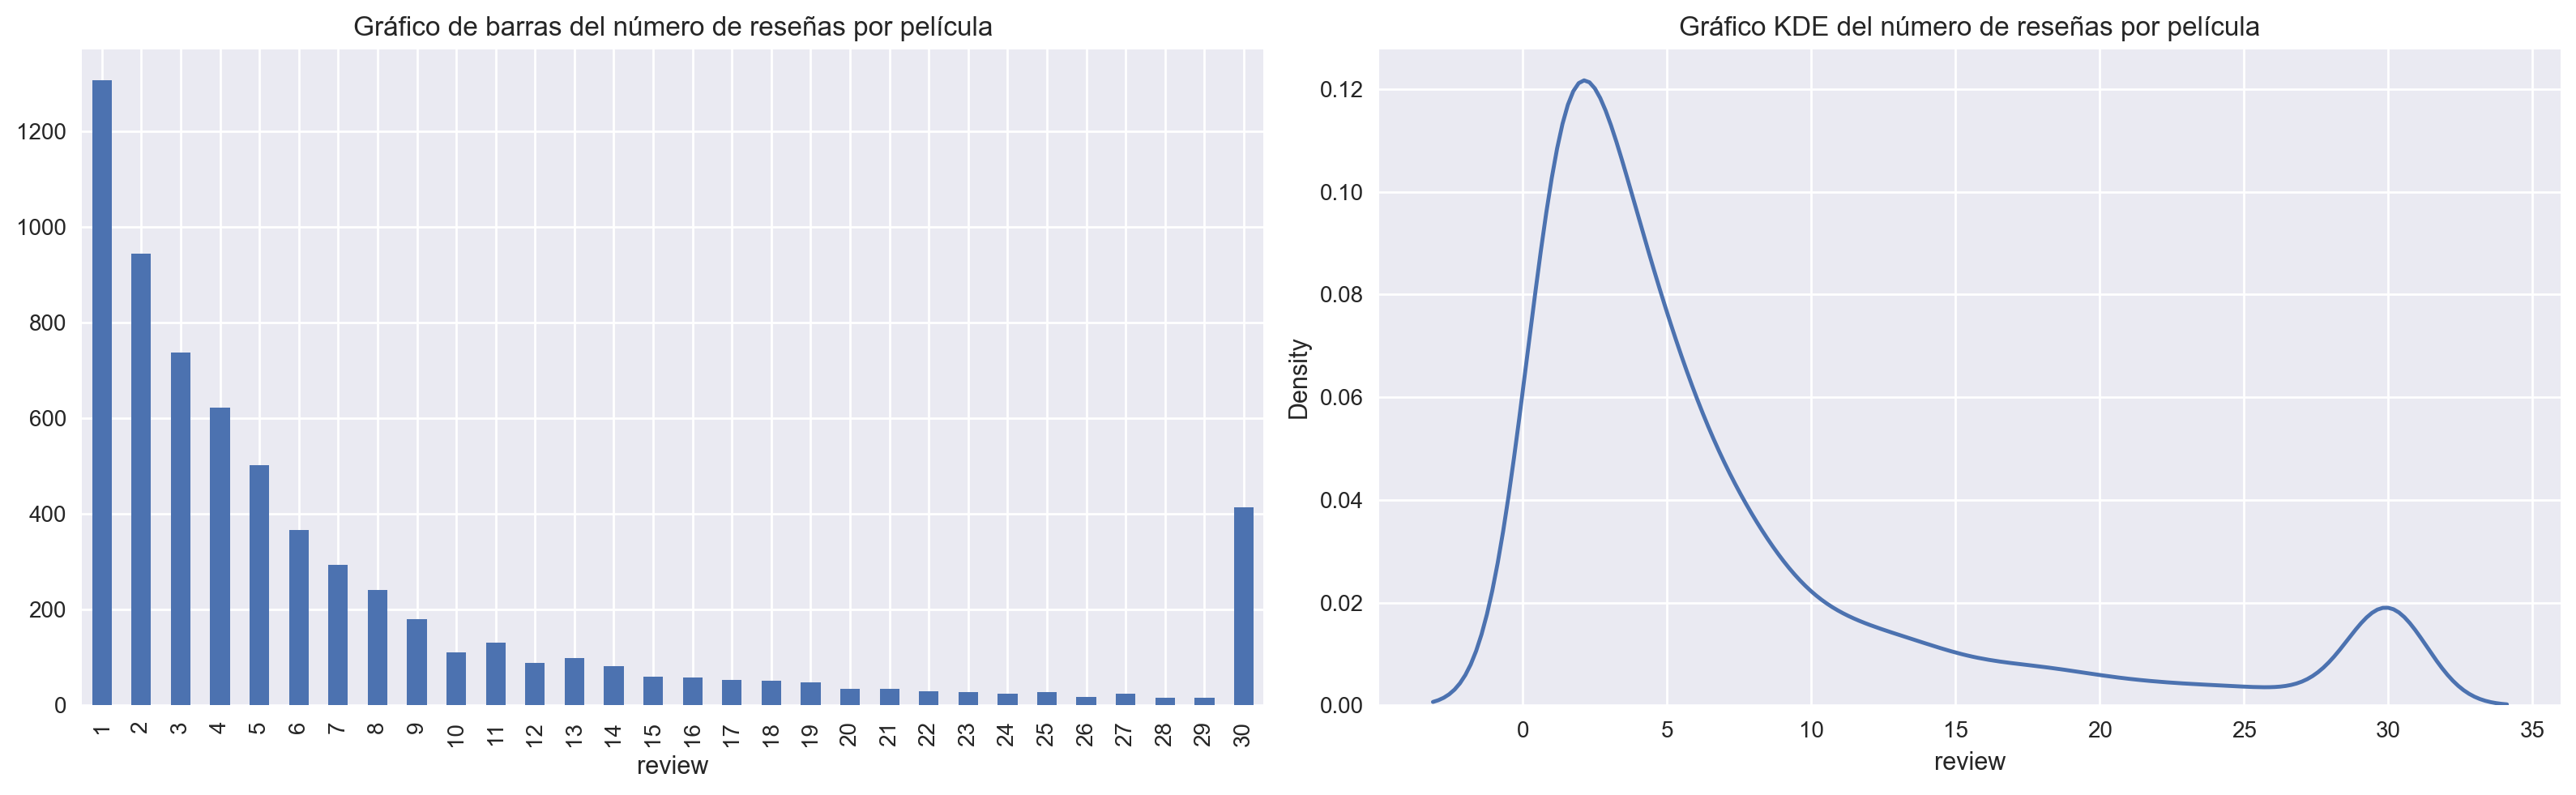

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras del número de reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE del número de reseñas por película')

fig.tight_layout()

Ambos gráficos indican que los datos tienen sesgo hacia la derecha, lo que significa que hay algunas películas con muchas reseñas y muchas películas con pocas reseñas. También muestran un pico en 1 reseña. La mayoría de las películas tienen solo unas pocas reseñas, lo que podría representar la tendencia general para la mayoría de las películas, mientras que unas pocas películas (blockbusters o películas aclamadas por la crítica) reciben una cantidad sustancial de atención. El pico en el gráfico de barras para películas con 30 o más reseñas podría indicar la presencia de valores atípicos.

In [12]:
df_reviews['pos'].value_counts()

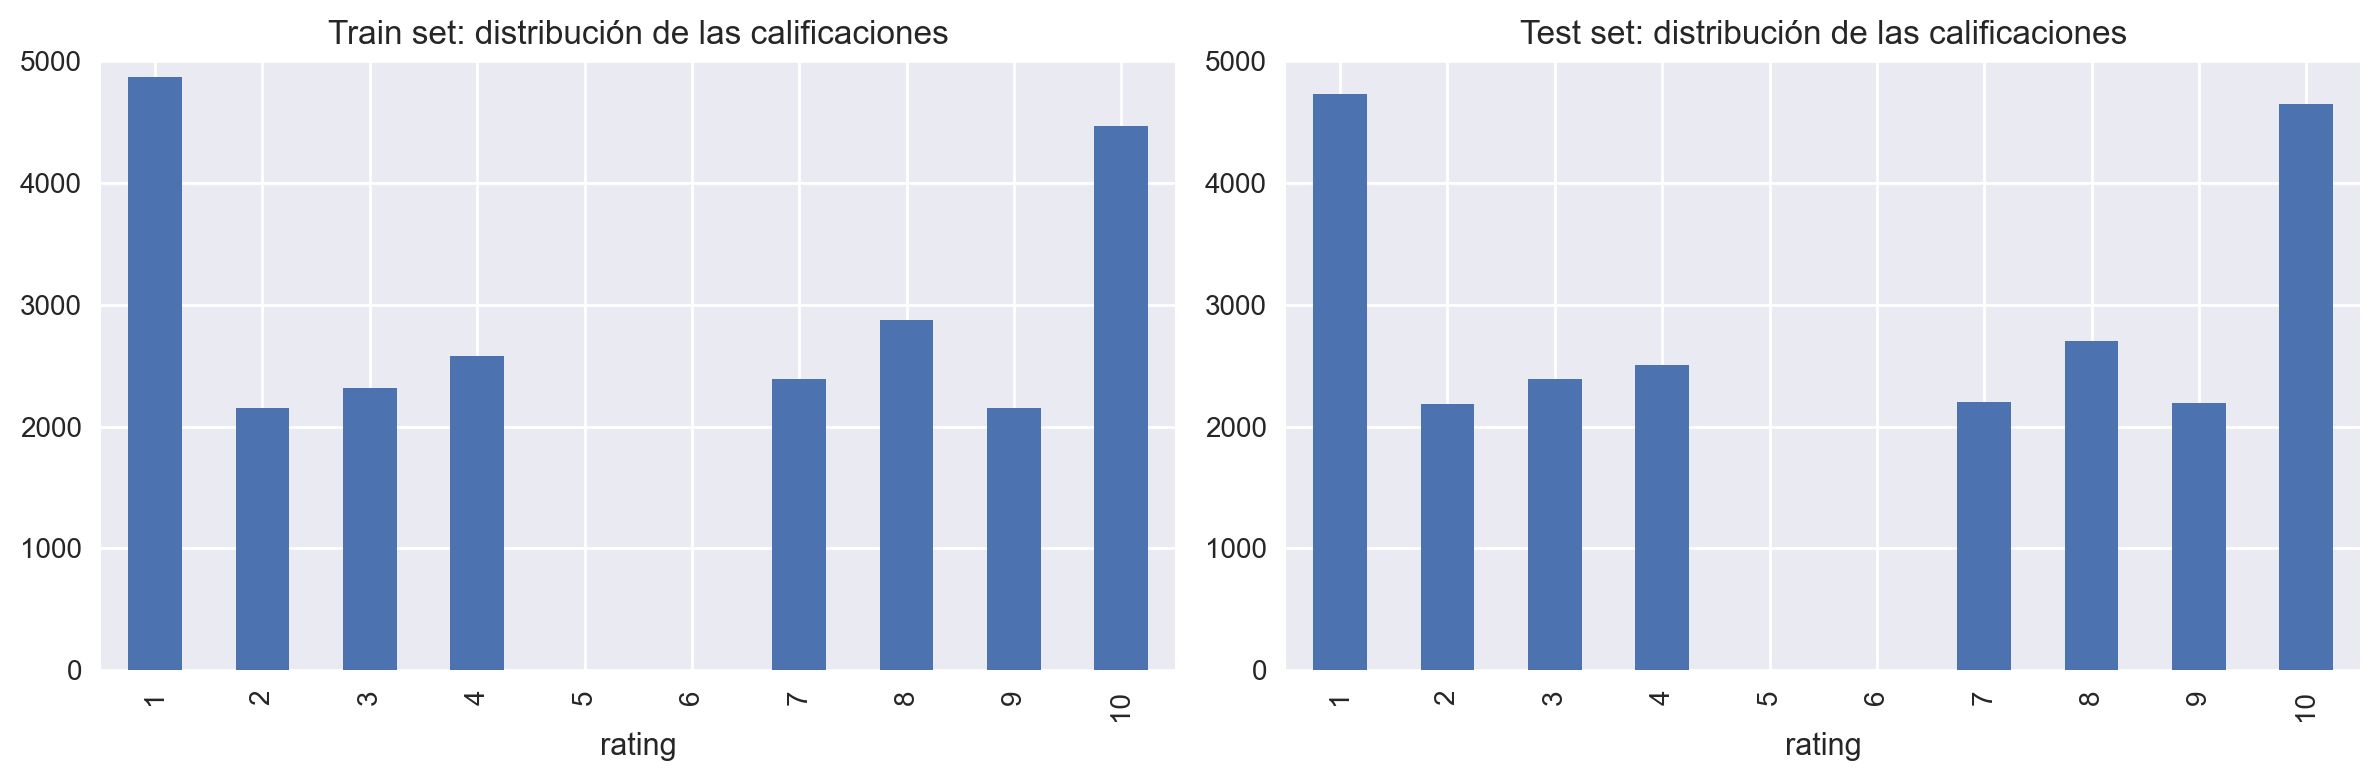

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribución de las calificaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: distribución de las calificaciones')

fig.tight_layout()

Los histogramas muestran la frecuencia de cada valor de calificación tanto en los conjuntos de entrenamiento como en los conjuntos de prueba. Tanto los conjuntos de entrenamiento como los de prueba muestran un patrón similar de distribución. La consistencia en el patrón de distribución entre los conjuntos de entrenamiento y prueba sugiere que la división entre los datos de entrenamiento y prueba se ha realizado adecuadamente, manteniendo una distribución similar de las calificaciones. 

Distribution of negative and positive reviews over the years for two parts of the dataset

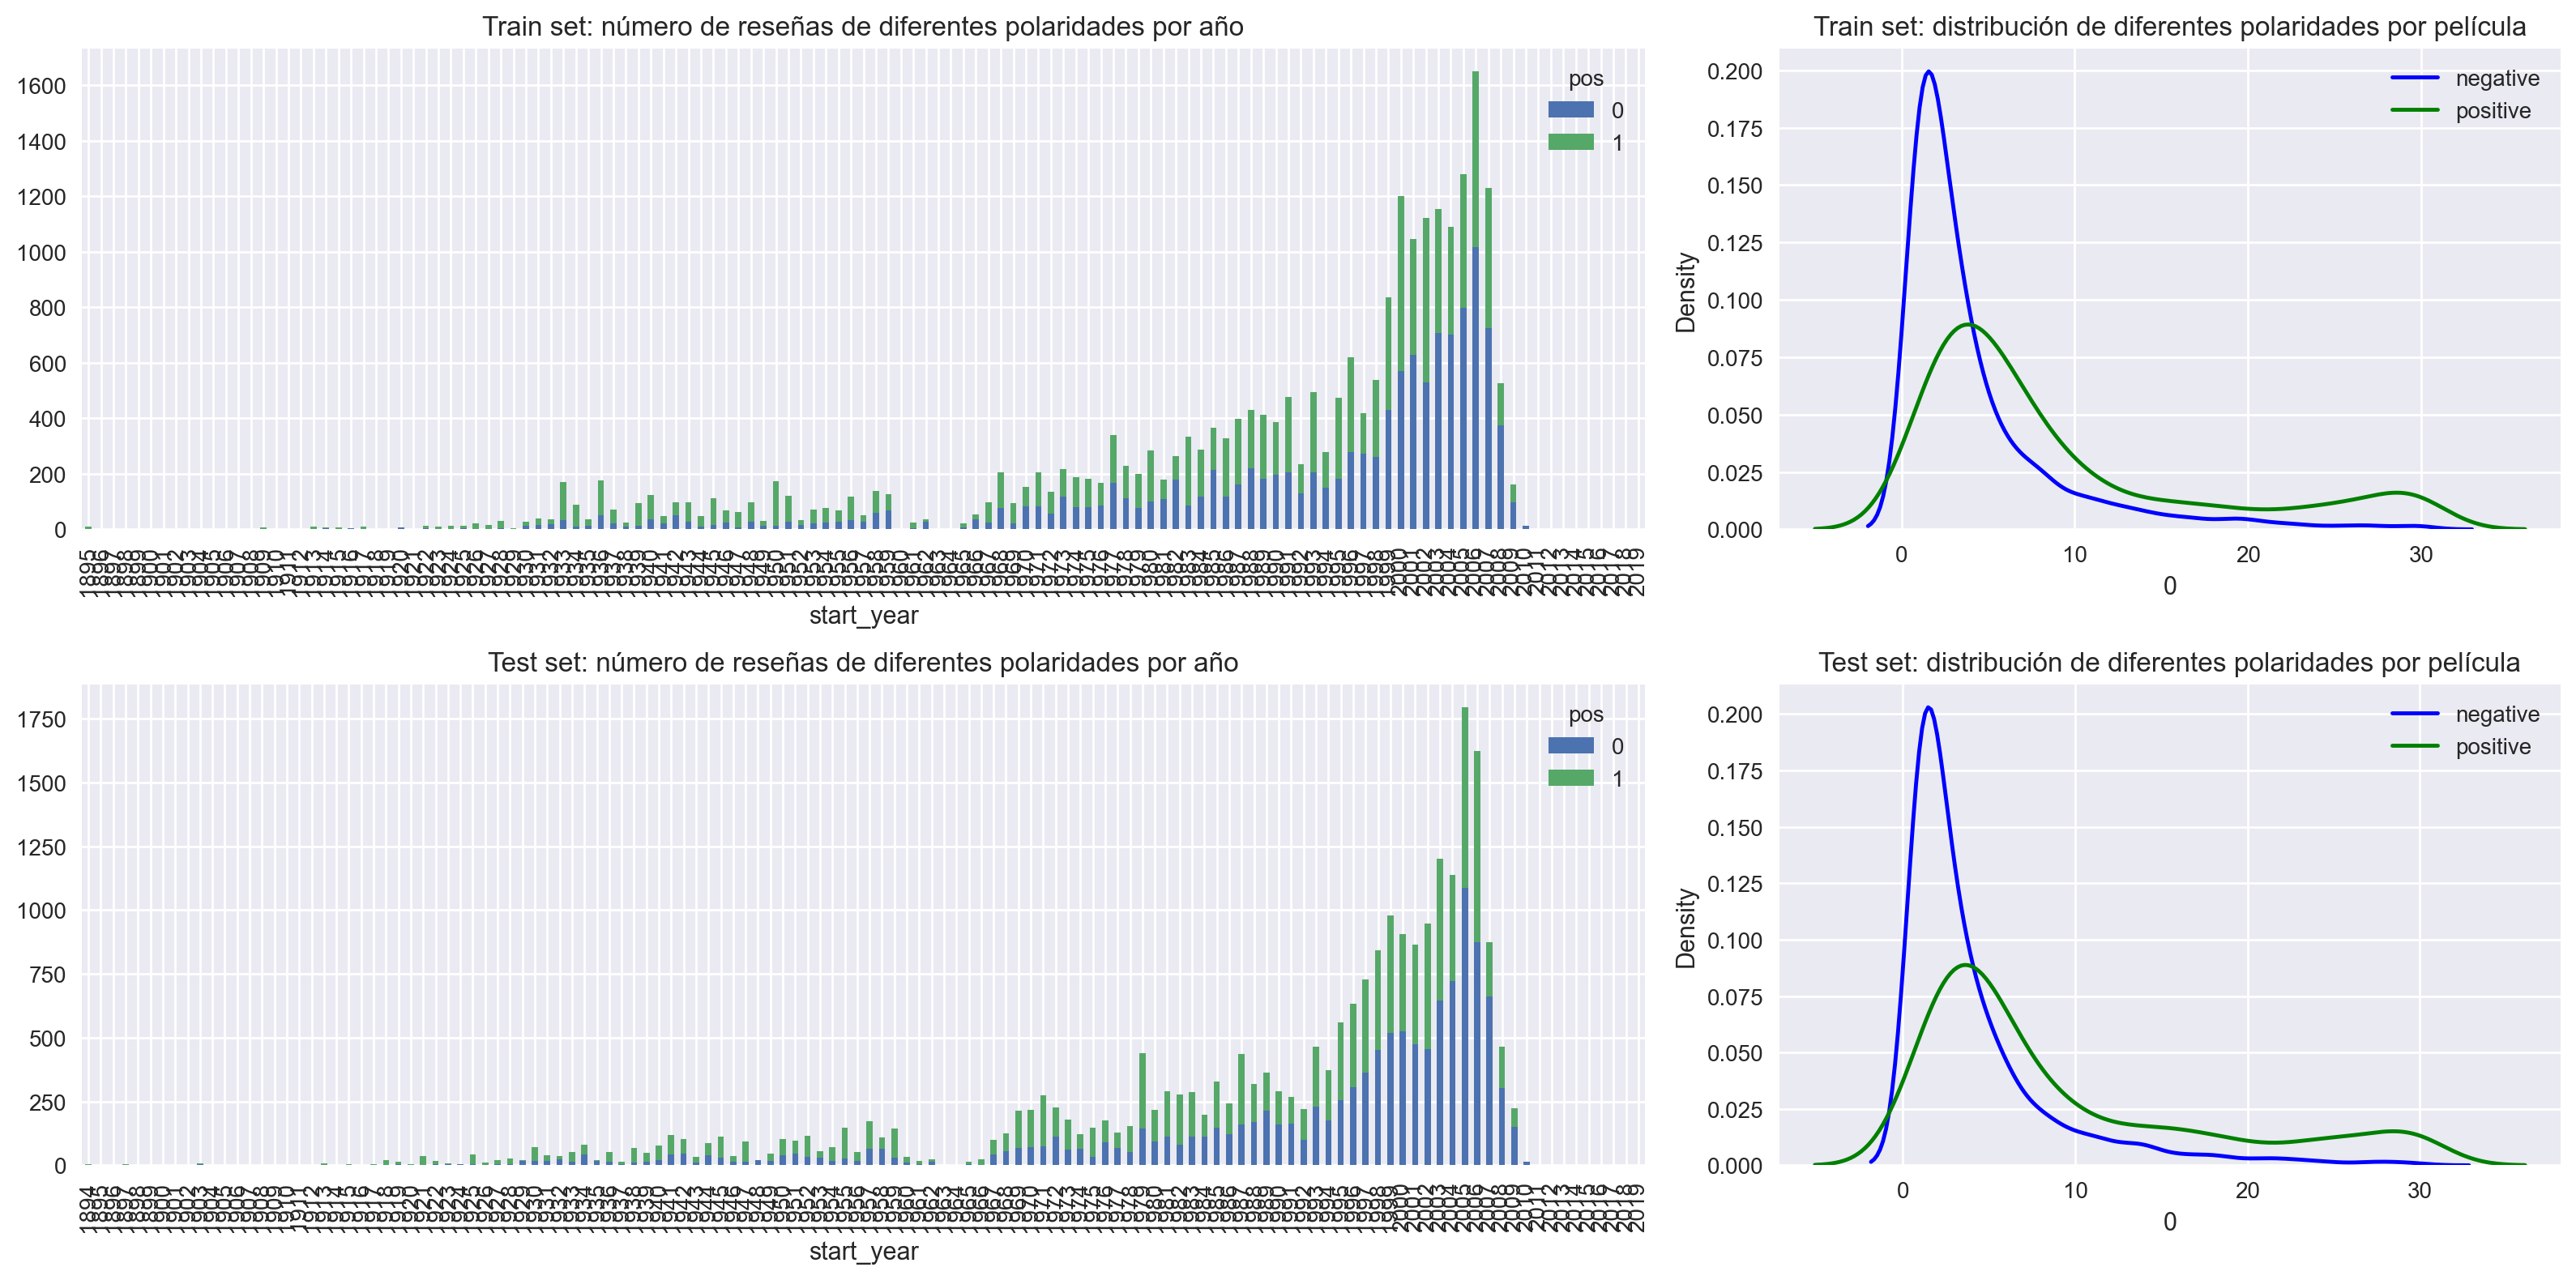

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train set: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Train set: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Test set: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto.

In [15]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [16]:
# Define una función para normalizar el texto
def normalize_text(text):
    # Convertir texto a minúsculas
    text = text.lower()
    # Eliminar dígitos
    text = re.sub(r'\d+', '', text)
    # Eliminar signos de puntuación
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Aplicar la función de normalización a cada reseña en el DataFrame
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

## División Train / Test

El conjunto de datos ya está dividido en partes de entrenamiento/prueba en la columna ds_part

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

## Trabajar con modelos

### Model 0 - Constante

In [18]:
# Crear un objeto DummyClassifier con una estrategia para predecir siempre la clase más frecuente
dummy_model = DummyClassifier(strategy='constant', constant=1)

# Ajustar el modelo dummy con los datos de entrenamiento
dummy_model.fit(df_reviews_train['review_norm'], train_target)

In [19]:
def evaluate_model(model, train_data, train_labels, test_data, test_labels):
    train_predictions = model.predict(train_data)
    test_predictions = model.predict(test_data)
    
    train_accuracy = metrics.accuracy_score(train_labels, train_predictions)
    test_accuracy = metrics.accuracy_score(test_labels, test_predictions)
    
    train_f1 = metrics.f1_score(train_labels, train_predictions, average='weighted')
    test_f1 = metrics.f1_score(test_labels, test_predictions, average='weighted')
    
    train_aps = metrics.average_precision_score(train_labels, train_predictions, average='weighted')
    test_aps = metrics.average_precision_score(test_labels, test_predictions, average='weighted')
    
    train_roc_auc = metrics.roc_auc_score(train_labels, train_predictions, average='weighted', multi_class='ovr')
    test_roc_auc = metrics.roc_auc_score(test_labels, test_predictions, average='weighted', multi_class='ovr')
    
    results = pd.DataFrame({
        'train': [train_accuracy, train_f1, train_aps, train_roc_auc],
        'test': [test_accuracy, test_f1, test_aps, test_roc_auc]
    }, index=['Accuracy', 'F1', 'APS', 'ROC AUC'])
    
    return results

In [23]:
# Evaluar el modelo dummy
results = evaluate_model(dummy_model, 
                         df_reviews_train['review_norm'], train_target, 
                         df_reviews_test['review_norm'], test_target)

print(results)

### Modelo 1 - NLTK, TF-IDF and LR

TF-IDF

In [29]:
# Descargar recursos necesarios de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Cargar palabras vacías (stopwords) y convertir el conjunto en una lista
english_stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Función para tokenizar y lematizar el texto
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in english_stopwords]
    return ' '.join(tokens)

# Aplicar la función de preprocesamiento al corpus
df_reviews_train['review_preprocessed'] = df_reviews_train['review_norm'].apply(preprocess_text)
df_reviews_test['review_preprocessed'] = df_reviews_test['review_norm'].apply(preprocess_text)

# Inicializar un TfidfVectorizer con stopwords y ajustarlo con los datos de entrenamiento
tfidf_vectorizer = TfidfVectorizer()

# Ajustar y transformar los datos de entrenamiento para crear características TF-IDF
train_features_1 = tfidf_vectorizer.fit_transform(df_reviews_train['review_preprocessed'])

# Transformar los datos de prueba para crear características TF-IDF
test_features_1 = tfidf_vectorizer.transform(df_reviews_test['review_preprocessed'])


In [28]:
# Inicializar un modelo de Regresión Logística
model_1 = LogisticRegression(random_state=0)

# Entrenar el modelo con los datos de entrenamiento y las etiquetas correspondientes
model_1.fit(train_features_1, train_target)

In [27]:
# Evaluar el modelo
results = evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

print(results)

### Modelo 3 - spaCy, TF-IDF and LR

In [28]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [29]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [30]:
# Aplicar la función de preprocesamiento de texto a la columna 'review_norm' de los datos de entrenamiento y prueba.
df_reviews_train['review_lemma'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_lemma'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [31]:
# Inicializar un TfidfVectorizer sin pasar las stopwords ya que ya hemos realizado el preprocesamiento
tfidf_vectorizer_3 = TfidfVectorizer()

# Ajustar y transformar los datos de entrenamiento para crear características TF-IDF
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_lemma'])

# Transformar los datos de prueba para crear características TF-IDF
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_lemma'])

In [32]:
# Inicializar el modelo de Regresión Logística
model_3 = LogisticRegression()

# Entrenar el modelo con los datos de entrenamiento
model_3.fit(train_features_3, train_target)

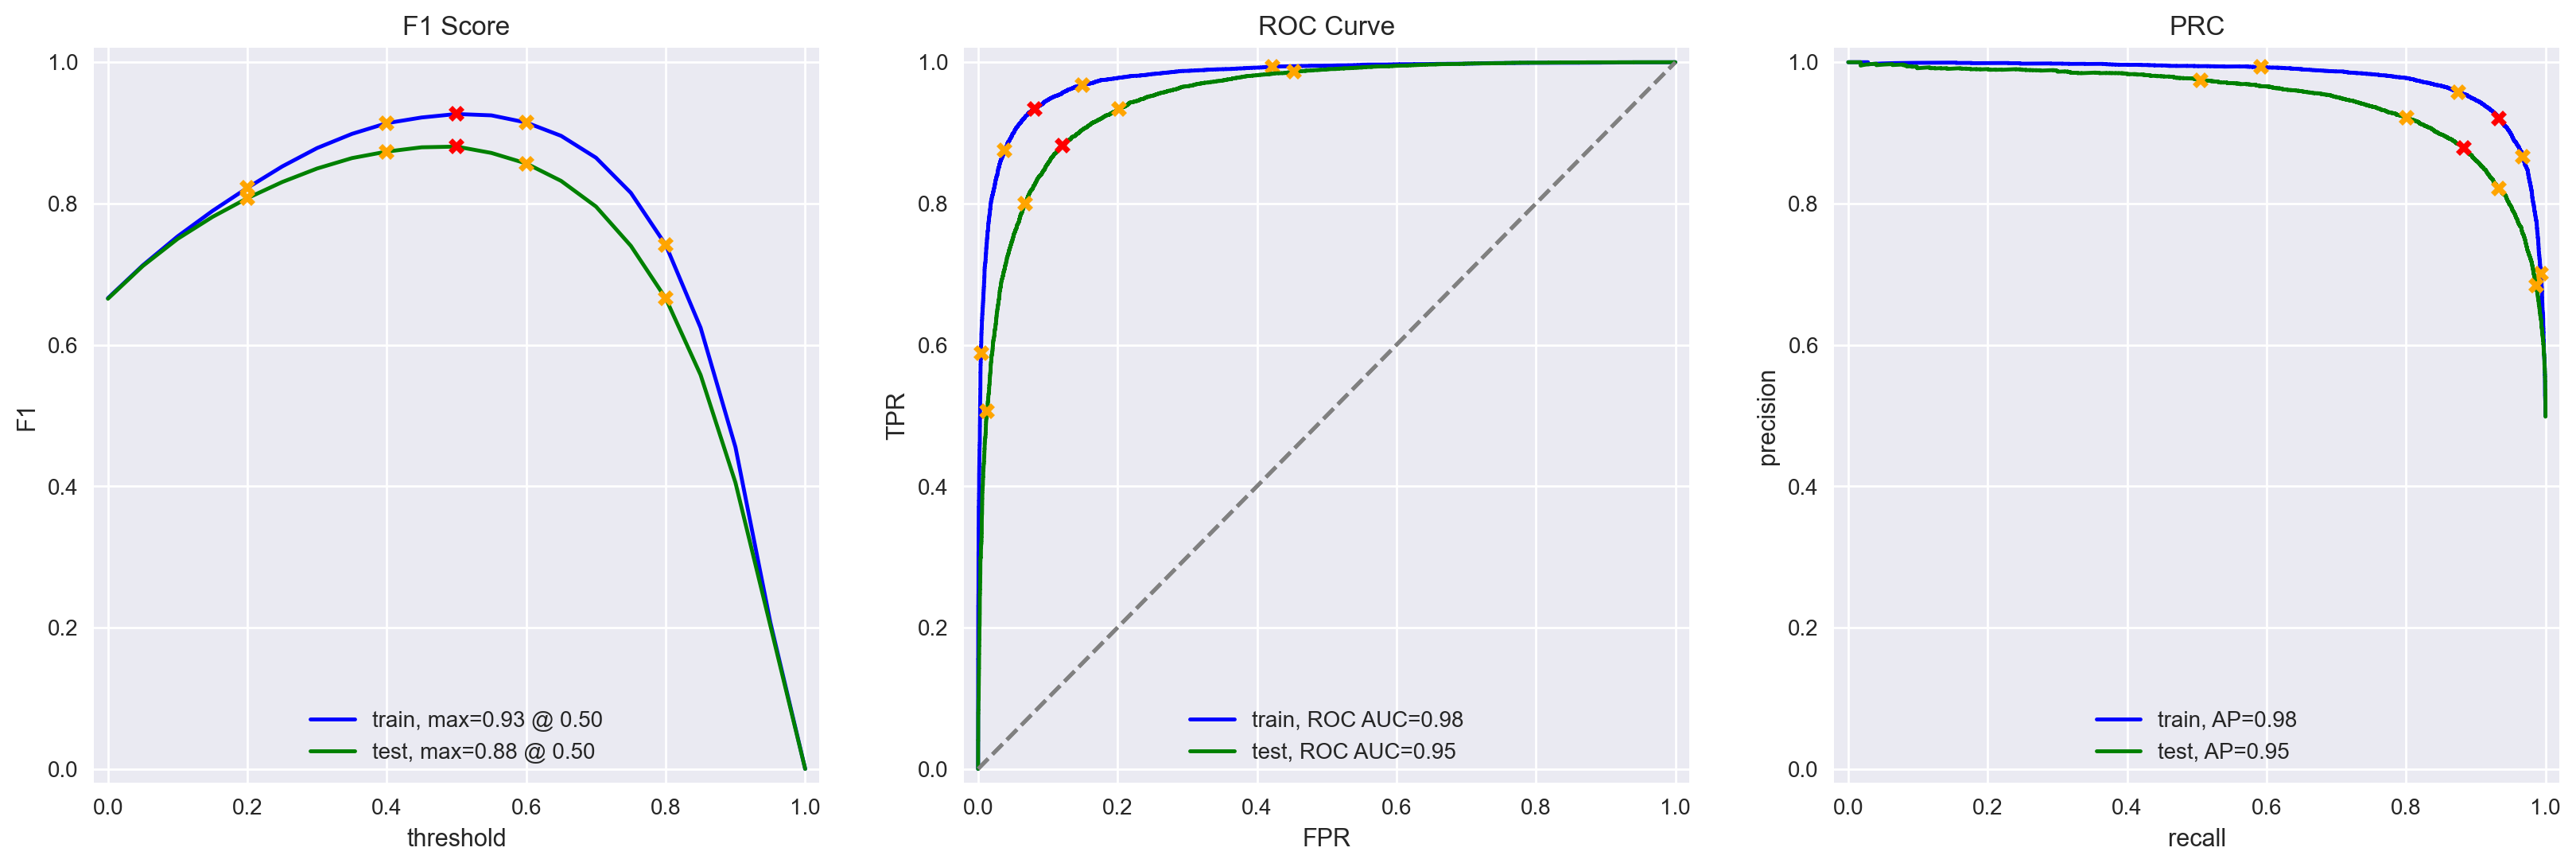

In [33]:
# Evaluar el modelo
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Modelo 4 - spaCy, TF-IDF and LGBMClassifier

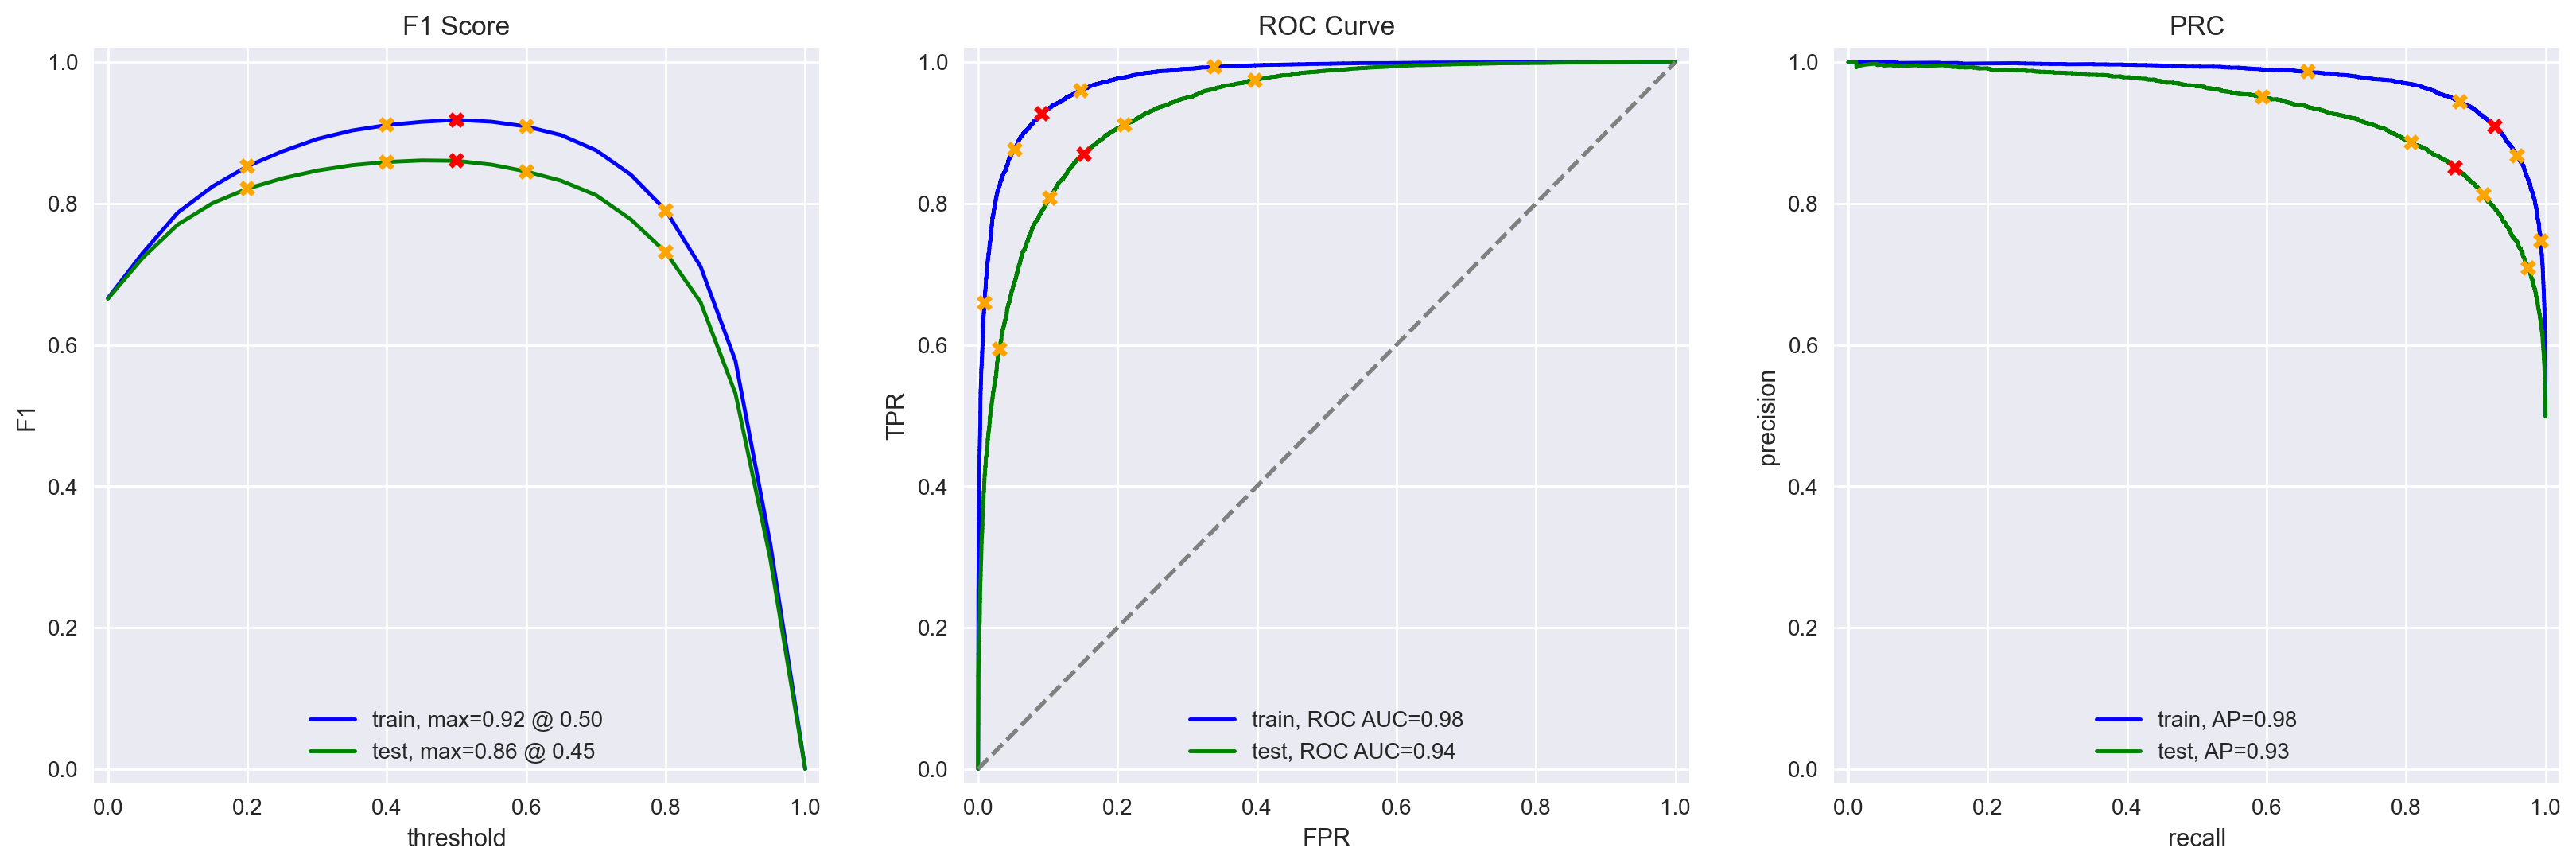

In [34]:
# Crear y entrenar un modelo LGBMClassifier
lgbm_model = LGBMClassifier(random_state=12345, n_jobs=-1)
lgbm_model.fit(train_features_3, train_target)

# Evaluar el modelo
evaluate_model(lgbm_model, train_features_3, train_target, test_features_3, test_target)

###  Model 9 - BERT

In [35]:
# Inicializar el tokenizer y la configuración del modelo
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [36]:

def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    # Convertir textos a tokens, rellenar hasta la longitud máxima y crear máscaras de atención
    ids_list = []
    attention_mask_list = []
    for text in texts:
        # Tokenizar el texto y añadir tokens especiales ([CLS], [SEP])
        encoded_dict = tokenizer.encode_plus(
            text,                      # Input text
            add_special_tokens=True,   # Agregar '[CLS]' and '[SEP]'
            max_length=max_length,     # Rellenar y truncar las frases
            pad_to_max_length=True,    # Rellenar todas hasta max_length
            return_attention_mask=True,# Construir attention masks
            return_tensors='pt',       # Devolver los tensores PyTorch
        )
        ids_list.append(encoded_dict['input_ids'])
        attention_mask_list.append(encoded_dict['attention_mask'])
    
    # Aplanar la lista de tensores en un solo tensor
    ids_list = torch.cat(ids_list, dim=0)
    attention_mask_list = torch.cat(attention_mask_list, dim=0)
    
    # Establecer el dispositivo basado en la disponibilidad y la preferencia
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # Procesar embeddings en lotes
    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        ids_batch = ids_list[batch_size*i:batch_size*(i+1)].to(device)
        attention_mask_batch = attention_mask_list[batch_size*i:batch_size*(i+1)].to(device)
        
        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [37]:
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

In [38]:
# Training a Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(train_features_9, train_target)

test_predictions = logreg_model.predict(test_features_9)
print(classification_report(test_target, test_predictions))

In [39]:
# Save the embeddings
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# Load the embeddings
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

In [40]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

Basado en los resultados

- El modelo muestra un rendimiento sólido y equilibrado en ambas clases, con alta precisión, recall y puntajes F1. Esto sugiere que es igualmente bueno identificando sentimientos positivos y negativos sin un sesgo significativo hacia ninguna clase.

- Los puntajes equilibrados y la alta precisión indican que los embeddings de BERT proporcionan un conjunto robusto de características para el análisis de sentimientos, permitiendo que el modelo de Regresión Logística capture y clasifique de manera efectiva el sentimiento expresado en las reseñas.

- Dada la complejidad y variabilidad del lenguaje natural, una precisión del 0.86 es meritorio, especialmente para un modelo relativamente simple como la Regresión Logística combinada con embeddings potentes de BERT.

- El número casi igual de instancias en cada clase ayuda a garantizar que las métricas de rendimiento del modelo no estén sesgadas por el desequilibrio de clases, lo que hace que los puntajes altos sean aún más significativos.


## Mis reseñas

In [30]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

### Modelo 2

In [43]:
texts = my_reviews['review_norm']
texts_transformed = tfidf_vectorizer.transform(texts)
my_reviews_pred_prob = model_1.predict_proba(texts_transformed)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 3

In [44]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 4

In [46]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = lgbm_model.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 9

In [48]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = logreg_model.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

El rendimiento de los modelos en las reseñas proporcionadas revela diferencias distintas en cómo evalúan el sentimiento, lo que indica variaciones en la sensibilidad, especificidad y posiblemente en las características subyacentes que priorizan durante la predicción. Aquí tienes un análisis breve del rendimiento de cada modelo basado en las probabilidades predichas para el sentimiento de cada reseña:

Modelo 2: Linear SVM con TF-IDF
- Sensitivity: Este modelo parece ser conservador en sus predicciones, inclinándose principalmente hacia un sentimiento neutro a negativo (probabilidades más bajas) en una variedad de reseñas. Solo muestra una alta confianza en el sentimiento positivo para la reseña sobre Netflix, lo que indica una posible preferencia por indicadores positivos explícitos.
- Specificity: El modelo es bueno para identificar sentimientos claramente negativos con puntuaciones bajas, pero tiene dificultades con expresiones positivas matizadas, como se observa en las puntuaciones moderadas para algunas reseñas positivas.

Modelo 3: Logistic Regression con TF-IDF
- Sensitivity: Similar al Modelo 2, este modelo es conservador pero muestra probabilidades ligeramente más altas en promedio para las reseñas positivas. Es más confiado en su evaluación de la reseña sobre Netflix y una película decente, lo que indica que podría ser mejor para captar positividad matizada que el Modelo 2.
- Specificity: Este modelo identifica eficazmente sentimientos fuertemente negativos, pero al igual que el Modelo 2, puede malinterpretar sentimientos matizados o mixtos.

Modelo 4: LightGBM con TF-IDF
- Sensitivity: Este modelo tiene un rango más amplio de predicciones, lo que indica una sensibilidad diferente a las características dentro del texto. Es más optimista, asignando probabilidades más altas a sentimientos positivos pero también mostrando probabilidades más altas para algunas reseñas negativas.
- Specificity: Su especificidad parece comprometida ya que asigna probabilidades moderadas a altas en general, lo que podría indicar un desafío para distinguir entre sentimientos negativos y positivos matizados.

Modelo 9: Logistic Regression con BERT Embeddings
- Sensitivity: Este modelo muestra un contraste marcado en sus predicciones, con probabilidades altas para sentimientos positivos y muy bajas para negativos, lo que indica una diferenciación fuerte entre sentimientos positivos y negativos basada en los embeddings de BERT.
- Specificity: Este modelo sobresale en identificar tanto sentimientos fuertemente positivos como fuertemente negativos, como lo indica el alto contraste en sus predicciones. Esto sugiere una alta especificidad, especialmente en el reconocimiento de expresiones claras de sentimiento.

Resumen del rendimiento:

- Manejo de Sentimientos Matizados: El Modelo 9 (BERT) se destaca por su capacidad para diferenciar claramente entre sentimientos positivos y negativos, probablemente debido a la rica información contextual capturada por los embeddings de BERT. Los Modelos 2 y 3 son más conservadores, posiblemente debido a limitaciones en capturar sentimientos matizados con características TF-IDF. El Modelo 4 muestra un enfoque variado pero podría tener dificultades con la especificidad.
- Sensitivity and Specificity: El Modelo 9 demuestra alta sensibilidad y especificidad, especialmente en la distinción de sentimientos positivos. Los Modelos 2 y 3 son más conservadores, posiblemente inclinándose hacia la precaución y por lo tanto potencialmente omitiendo sentimientos matizados. El rango más amplio de predicción del Modelo 4 sugiere una interpretación diferente de las características, pero podría necesitar refinamiento para mejorar la especificidad.
- Efectividad General: Basado en las predicciones proporcionadas, el Modelo 9 parece ser el más efectivo en capturar una amplia gama de sentimientos, desde fuertemente negativos hasta fuertemente positivos, lo que indica el poder de los embeddings de BERT en tareas de análisis de sentimientos. Los otros modelos, aunque tienen sus fortalezas, muestran diferentes grados de efectividad, con áreas potenciales para mejorar en el manejo de sentimientos matizados o mixtos.

Estas observaciones sugieren que la elección del modelo y las características (TF-IDF vs. BERT) tienen un impacto significativo en el rendimiento del análisis de sentimientos, especialmente en el manejo de expresiones matizadas de sentimiento.

## Conclusiones

Hallazgos clave:

- Variabilidad del Rendimiento del Modelo: Hubo una variación notable en el rendimiento de los modelos, influenciada por el tipo de extracción de características (TF-IDF vs. embeddings de BERT) y el algoritmo utilizado. Esta variación subraya la importancia de elegir la combinación adecuada de representación de características y técnica de aprendizaje automático basada en los requisitos específicos de la tarea de análisis de sentimientos.

- Eficacia de BERT: El modelo que utiliza embeddings de BERT demostró un rendimiento superior en la distinción entre sentimientos con mayor precisión. Este modelo mostró una notable capacidad para capturar expresiones matizadas de sentimiento, probablemente debido al profundo entendimiento contextual del lenguaje de BERT, que supera las capacidades de métodos tradicionales de vectorización como TF-IDF.

- Desafíos con Modelos Tradicionales: Los modelos tradicionales que utilizan vectorización TF-IDF mostraron un enfoque más conservador en la predicción de sentimientos, a menudo inclinándose hacia clasificaciones de sentimiento neutro o menos definitivas. Si bien son efectivos en ciertos contextos, estos modelos pueden enfrentar dificultades con la complejidad y sutileza del lenguaje humano, especialmente al tratar con sentimientos matizados o mixtos.

La exploración de diferentes modelos para el análisis de sentimientos ha resaltado el papel crítico de la representación de características y la elección del modelo en la interpretación efectiva de sentimientos en texto. El rendimiento superior del modelo basado en BERT subraya los avances en la tecnología de procesamiento del lenguaje natural (NLP), ofreciendo una comprensión más profunda de las tareas de análisis de sentimientos. Sin embargo, la variabilidad en el rendimiento de los modelos también sugiere que no existe una solución única; la elección del modelo debe adaptarse a los matices específicos del conjunto de datos y a los objetivos del análisis de sentimientos. En el futuro, aprovechar técnicas avanzadas de NLP y explorar enfoques de modelado innovadores será clave para mejorar la precisión y aplicabilidad del análisis de sentimientos en diversos dominios.